In [1]:
#!pip3 install --user astropy

In [98]:
import numpy as np
import astropy as ap
import pandas as pd
from astropy.io import fits
import scipy.linalg as slg
import matplotlib.pyplot as plt
import glob
import os
from IPython.display import Image

In [82]:
run_path = "/home/portmanm/run2_1000_galfit"
#run_path = "/home/portmanm/run3_1000_galfit_psf"
sparc_in = "sparcfire-in"
sparc_out = "sparcfire-out"
sparc_tmp = "sparcfire-tmp"
galfits_tmp = "galfits"
galfit_masks = "galfit_masks"
galfit_out = "all_galfit_out"

In [83]:
def check_galfit_chi(gal_name, base_path):
    # An example line
    # # Chi^2/nu = 4.661,  Chi^2 = 12025.575,  Ndof = 2580
    
    galfit_txt_out = "galfit.01" # in the future galfit.01 may change
    filename = os.path.join(base_path, gal_name, galfit_txt_out)
    with open(filename, "r") as f:
        for line in f:
            if "Chi" in line:
                chi_line = line.strip("# ")
    
    # This also works but it's quite devious...
    # chi_line.replace("^", "").replace("/", "_").replace(",  ", "\n").lower()
    # exec(chi_line)
    
    out_vals = chi_line.split(",")
    chi2_nu = float(out_vals[0].strip().split("=")[-1])
    chi2 = float(out_vals[1].strip().split("=")[-1])
    ndof = int(out_vals[2].strip().split("=")[-1])
    
    return chi2_nu, chi2, ndof

In [151]:
norms = {}
#residual_arrays = {}
total_gal = len(glob.glob(os.path.join(run_path, sparc_in, "*.fits")))
outpath = os.path.join(run_path, sparc_out)#, galfit_out)
temppath = os.path.join(run_path, sparc_tmp, galfits_tmp)
maskpath  = os.path.join(run_path, sparc_tmp, galfit_masks)
#successes = [os.path.basename(i) for i in glob.glob(os.path.join(temppath, "*.fits"))]

for i in glob.glob(os.path.join(temppath, "*.fits")):
    fits_file = fits.open(i)
    filename  = os.path.basename(i)
    galaxy_name = filename.split("_")[0]
    
    star_mask_name = f"{galaxy_name}_star-rm.fits"
    
    mask_fits_name = os.path.join(maskpath, star_mask_name)
    mask_fits_file = fits.open(mask_fits_name)
    
    crop_box = fits_file[2].header["FITSECT"]
    crop_box = eval(crop_box.replace(":", ","))
    
    # To adjust for python indexing
    box_min, box_max = crop_box[0] - 1, crop_box[1]
    #print(mask_fits_file[0].data[box_min:box_max, box_min:box_max])
    #print(star_mask_name)
    
    try:
        masked_observation = fits_file[1].data - (fits_file[1].data * mask_fits_file[0].data[box_min:box_max, box_min:box_max])
        #masked_model = fits_file[2].data - mask_fits_file[0].data[box_min, box_max]
    except:
        print(f"There is likely an observation error with galaxy {galaxy_name}, continuing...")
        #print(np.shape(mask_fits_file[0].data))
        #print(np.shape(fits_file[1].data))
        #print(crop_box)
        continue
    residual = masked_observation - fits_file[2].data
    #residual_arrays[filename] = residual
    
    try:
        norms[filename] = *check_galfit_chi(galaxy_name, outpath)[:2], round(slg.norm(residual), 3), round(slg.norm(fits_file[3].data), 3), residual
        #print(f"{galaxy_name}", round(slg.norm(residual), 3))
        #norms[filename] = check_galfit_chi(galaxy_name, outpath)[:2]#, slg.norm(fits_file[3].data)
    # for infs, nans in residual
    except ValueError:
        pass
    
    except FileNotFoundError:
        print(f"Could not find galfit.# output file for {filename}. Continuing...")
        pass
    
    fits_file.close()
    mask_fits_file.close()
#glob.glob("./" + galaxy_path + '/' + galaxy_name + '.tsv')[0]

There is likely an observation error with galaxy 1237667910602522764, continuing...
There is likely an observation error with galaxy 1237671140406919323, continuing...


In [155]:
norms_df = pd.DataFrame(norms).T
norms_df.rename(columns={0: 'chi^2_nu', 1: 'chi^2', 2 : 'norm_masked_residual', 3 : 'norm_galfit_residual', 4 : 'masked_residual_array'}, inplace=True)

In [177]:
#norms = dict(sorted(norms.items(), key=lambda item: item[1][2]))
norms_df = norms_df.sort_values(by=['norm_masked_residual']) #, inplace=True)
#norm_items = list(norms.items())

In [178]:
png_dir = os.path.join(run_path, sparc_out, galfit_out, "galfit_png/")

In [15]:
# Grab top 1000 highest resolution galaxies from Darren's 27K and run this on those
# Change pitch angle plotting to only plot sparcfire's line between r_in and r_out and see how that compare to galfit
# Tile residuals for presentation???

1237671139873128630_out.fits
chi^2/nu = 0.66
chi^2 = 1447.07
Norm masked residual = 494.86
Norm GALFIT residual = 494.86


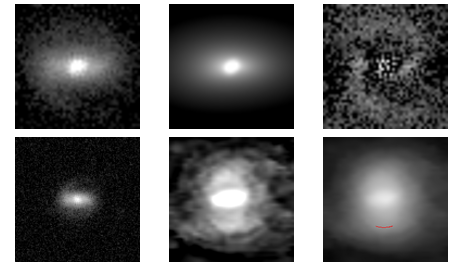

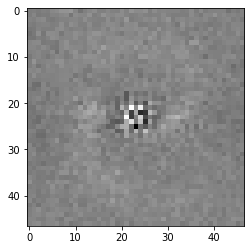

In [205]:
# https://stackoverflow.com/questions/32370281/how-to-embed-image-or-picture-in-jupyter-notebook-either-from-a-local-machine-o
index_num = 500
galaxy_info = norms_df.iloc[index_num]

# iloc returns a series, name returns the name of the row
galaxy_out_name = galaxy_info.name
chi2_nu = galaxy_info[0]
chi2 = galaxy_info[1]
norm_masked_residual = galaxy_info[2]
norm_galfit_residual = galaxy_info[3]
masked_residual = galaxy_info[-1]

print(galaxy_out_name)
print(f"chi^2/nu = {chi2_nu:.2f}")
print(f"chi^2 = {chi2:.2f}")
print(f"Norm masked residual = {norm_masked_residual:.2f}")
print(f"Norm GALFIT residual = {norm_galfit_residual:.2f}")

residual_plot = plt.imshow(np.flipud(masked_residual[:,:]))
residual_plot.set_cmap('gray')
#cbar = plt.colorbar()

#plt.imshow(residual_plot)
#imgplot = plt.imshow(arr[:, :, 0])
out_str = galaxy_out_name.replace("out.fits", "combined.png").strip()
Image(filename = os.path.join(png_dir, out_str), width=600, height=600)


In [264]:
#print(len(test_list), len(norms), 717/809*100)
print(f"Total number of galaxies attempted: {total_gal}")
print(f"Number of Galfit models generated: {len(norms)}")
#print(f"Residuals below arbitrary cutoff: {len(test_list)}")
print()
#print(f"Percent models generated: {100*len(norms)/total_gal:.2f}%")
#print(f"Percent successful below cutoff excluding failures: {100*len(test_list)/len(norms):.2f}%")
#print(f"Percent successful below cutoff including failures: {100*len(test_list)/total_gal:.2f}%")

Total number of galaxies attempted: 1000
Number of Galfit models generated: 934

